In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [5]:
train_df = pd.read_csv(Path('Resources/Generator/2019_loans.csv'))
test_df = pd.read_csv(Path('Resources/Generator/2020Q1_loans.csv'))

In [6]:
# Convert categorical data to numeric
train_dummies = pd.get_dummies(train_df,drop_first=True)
test_dummies = pd.get_dummies(test_df,drop_first=True)
train_dummies.head(2)

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,hardship_flag_Y,debt_settlement_flag_Y,target_low_risk
0,7000.0,0.1894,256.38,75000.0,28.62,0.0,2.0,20.0,0.0,40414.0,...,1,0,0,0,0,0,0,0,0,1
1,40000.0,0.1614,975.71,102000.0,11.72,2.0,0.0,10.0,0.0,43531.0,...,1,0,0,1,0,1,0,0,0,1


In [7]:
#separate target feature for training data

X_train=train_dummies.drop(columns=['target_low_risk'])
y_train=train_dummies['target_low_risk']


In [8]:
# separate target feature for testing data
X_test=test_dummies.drop(columns=['target_low_risk'])
y_test=test_dummies['target_low_risk']

In [9]:
# add missing dummy variables to testing set
missing_cols = set( X_train.columns ) - set( X_test.columns )
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]


In [20]:
# Train the Logistic Regression model on the unscaled data and print the model score
lr = LogisticRegression(max_iter=1000,random_state=1)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(f'model score for test data: {lr.score(X_test,y_test)}')
print(f'model score for train data: {lr.score(X_train,y_train)}')


model score for test data: 0.5667800935772012
model score for train data: 0.6974548440065681


In [21]:
# Train a Random Forest Classifier model on the scaled data and print the model score
rfc = RandomForestClassifier(n_estimators=600,random_state=1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(f'model score for test data: {rfc.score(X_test,y_test)}')
print(f'model score for train data: {rfc.score(X_train,y_train)}')


model score for test data: 0.6384517226712038
model score for train data: 1.0


In [12]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Train the Logistic Regression model on the scaled data and print the model score
lr = LogisticRegression(max_iter=1000,random_state=1)
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)
print(f'model score for test data: {lr.score(X_test_scaled,y_test)}')
print(f'model score for train data: {lr.score(X_train_scaled,y_train)}')


model score for test data: 0.7594640578477244
model score for train data: 0.7108374384236453


In [23]:
# Train a Random Forest Classifier model on the scaled data and print the model score
rfc = RandomForestClassifier(n_estimators=600,random_state=1)
rfc.fit(X_train_scaled,y_train)
y_pred = rfc.predict(X_test_scaled)
print(f'model score for test data: {rfc.score(X_test_scaled,y_test)}')
print(f'model score for train data: {rfc.score(X_train_scaled,y_train)}')


model score for test data: 0.6378136962994471
model score for train data: 1.0


## Using random forest for feature selection 

In [15]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(rfc)
sel.fit(X_train_scaled, y_train)
X_selected_train=sel.transform(X_train)
X_selected_test=sel.transform(X_test)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)
reg = LogisticRegression(max_iter=400,random_state=1).fit(X_selected_train_scaled, y_train)
reg.score(X_selected_test_scaled, y_test)


0.7713738834538494

model score for test data: 0.7713738834538494
model score for train data: 0.7094417077175698
**********************************************************************
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      2351
           1       0.76      0.79      0.78      2351

    accuracy                           0.77      4702
   macro avg       0.77      0.77      0.77      4702
weighted avg       0.77      0.77      0.77      4702

**********************************************************************


<AxesSubplot:>

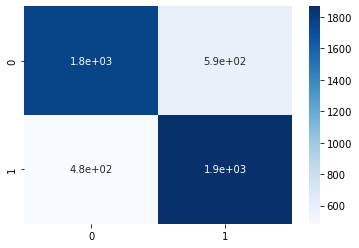

In [18]:
y_pred = reg.predict(X_selected_test_scaled)
print(f'model score for test data: {reg.score(X_selected_test_scaled,y_test)}')
print(f'model score for train data: {reg.score(X_selected_train_scaled,y_train)}')
print("*"*70)
print(classification_report(y_test,y_pred))
print("*"*70)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')